In [1]:
# This code simply loads traces and displays them in a spectrogram and in a plot
# It does not contain any training functions or parameters
# It was created to increase the readability of the main code and to enable the display of the loaded traces (Duh :P)


# This code contains code adapted from Nils Wisiol, sntrup4591761 and ANSSI-FR/ASCAD
# All snippets are marked accordingly as such
# from tqdm import tnrange

# General modules
import sys
from pathlib import Path


# Load data modules
from numpy import empty, zeros, uint16
from numpy.random import RandomState
import chipwhisperer as cw
import numpy as np
## Load data modules for DPA contest
# This library is from another GitHub library: https://github.com/yetifrisstlama/readTrc
# from readTrc import trc
from readTrc import Trc

# Plot traces
from scipy import signal, fftpack
import matplotlib.pyplot as plt
## Plot zoomed in
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# ASCAD: Adapted by Mahmoud Gharra to fit the NTRU Prime input


# returns traces and labels, as well as some important global meta_data

def load_database(my_database):
    # load traces
    print("++ Loading projects")
    project = cw.open_project(my_database)
    global KEY_LENGTH, TEXT_LENGTH, SAMPLE_HIGH, TRAINING_SLICE, TEST_NUM, TEST_SLICE

    # Organize trace data for MLP
    print("++ Organizing traces")
    KEY_LENGTH = TEXT_LENGTH = len(project.keys[0]) * 8 # TODO: reset
#     KEY_LENGTH = TEXT_LENGTH = len(project.keys[0]) # TODO: reset
    print("KEY_LENGTH: {}".format(KEY_LENGTH))
    print("project.keys[0][0]: {}".format(project.keys[0][0]))
    print("np.asarray(bytearray(project.keys[0]))", np.asarray(bytearray(project.keys[0])))

    # SET DATA RELATED GLOBALS REQUIRED FOR EXTRACTION
    sample_low = 0
    SAMPLE_HIGH = project.trace_manager().num_points() # length of singular trace
    sample_slice = slice(sample_low, SAMPLE_HIGH)
    sample_num = len(project.traces) # number of traces
#     print("sample num: ", sample_num)
    
    # organize traces in X matrix
    X = empty(shape=(sample_num, SAMPLE_HIGH - sample_low))

    # organize the operands in Y matrix
    count = 0
    
    y = empty(shape=(sample_num, KEY_LENGTH))
    for i in range(sample_num):
        # reproduce values
        
        # The next three lines were for debugging purposes. I'm sorry for doing printf debugging :p
#         print("key of sample {}: {}".format(i, project.keys[i]))
#         print("data type of key of sample {}: {}".format(i, type(project.keys[i])))
#         print("ISO-8859-1 encoding: {}".format(project.keys[i].decode("ISO-8859-1")))

        if (len(np.asarray(bytearray(project.keys[i])))) is not (int(KEY_LENGTH/8)):
            count += 1
#             print("Number of problematic traces raised to: {}".format(count))
#             print("actual key len: {}, expected length: {}".format(len(np.asarray(bytearray(project.keys[i]))), int(KEY_LENGTH/8)))
            continue
            
#         print("y[{}]: {}".format(i-count, np.asarray(bytearray(project.keys[i]))))
#         print("np.asarray(bytearray(project.keys[i])): {}".format(len(np.asarray(bytearray(project.keys[i])))))
        y[i-count] = np.asarray([int(char) for char in ''.join(['{0:08b}'.format(ff) for ff in np.asarray(bytearray(project.keys[0]))])])
#         y[i-count] = np.asarray(bytearray(project.keys[i]))
        X[i-count] = project.waves[i][sample_slice]

#     remove last {count} rows for having wrong KEY-Dimesions
    if i is not 0:
        y = y[0:-count]
        X = X[0:-count]

#     # transform generated key numbers to labels
#     y = np.array((y.T[1::2].T*(2**8)) + y.T[::2].T, dtype=np.int16)

    # the next 4 lines aren't needed because the labels for the sampler are ints starting at 0
#     unique = np.unique(y)
#     class_dic = dict([[unique[i], i] for i in range(len(unique))])
#     y_labelled = np.vectorize(class_dic.get)(y)
#     return X, y_labelled


    # SET DATA RELATED GLOBALS before returning (POST EXTRACTION)
    sample_low = 0
    SAMPLE_HIGH = project.trace_manager().num_points() # length of singular trace
    sample_slice = slice(sample_low, SAMPLE_HIGH)
    sample_num = len(project.traces) - count # number of traces
    
    training_num = sample_num - tst_len
    TRAINING_SLICE = slice(0, training_num)

    TEST_NUM = sample_num - training_num
    TEST_SLICE = slice(training_num, TEST_NUM + training_num)
    assert TEST_NUM + training_num <= sample_num
    assert training_num > 3*TEST_NUM


    return X, y


def read_parameters_from_file(param_filename):
    #read parameters for the train_model and load_traces functions
    #TODO: sanity checks on parameters
    param_file = open(param_filename,"r")

    #TODO: replace eval() by ast.linear_eval()
    my_parameters= eval(param_file.read())

    my_database = my_parameters["database"]
    my_database_title = my_parameters["database_title"]
    return my_database_title, my_database



# https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
def four_tr(traces, tmp_i, f_s):
    _Four = fftpack.fft(traces[tmp_i])
    _freqs = fftpack.fftfreq(len(traces[tmp_i])) * f_s
    
    return _Four, _freqs


In [3]:
# ASCAD: Adapted by Mahmoud Gharra to fit the NTRU Prime input


# returns traces and labels, as well as some important global meta_data

def load_database_DPA(my_database_traces, my_database_labels):
    # load traces
    
        
    global KEY_LENGTH, TEXT_LENGTH, SAMPLE_HIGH, TRAINING_SLICE, TEST_NUM, TEST_SLICE

    # Organize trace data for MLP
    print("++ Organizing traces")
    KEY_LENGTH = TEXT_LENGTH = 1
    
    print("KEY_LENGTH: {}".format(KEY_LENGTH))

    # get the first trace to get its dims
    trc = Trc()
    datX, datY, d = trc.open(my_database_traces + "/Z1Trace00000.trc")
    # SET DATA RELATED GLOBALS REQUIRED FOR EXTRACTION
    sample_low = 0
    SAMPLE_HIGH = len(datX)/32 # length of singular trace
    sample_slice = slice(sample_low, SAMPLE_HIGH)
    sample_num = 2000 # number of traces
#     print("sample num: ", sample_num)
    
    print("++ Loading projects")

    
    # organize traces in X matrix
    X = empty(shape=(sample_num, int(SAMPLE_HIGH) - sample_low + 1))
    
    # organize the operands in Y matrix
    y = empty(shape=(sample_num, KEY_LENGTH))
    
    f = open (my_database_labels , 'r')
    fs = []
    fs = [i for i in f]

    for i in range(sample_num):
        datX, datY, d = trc.open(my_database_traces + "/Z1Trace{:05d}.trc".format(i))
        X[i] = datY[0:int(len(datX)/4):8]
        y[i] = int(fs[i].split()[3], 16)


    # SET DATA RELATED GLOBALS before returning (POST EXTRACTION)
    sample_low = 0
    SAMPLE_HIGH = int(len(datX)/32) # length of singular trace
    sample_slice = slice(sample_low, SAMPLE_HIGH)
    sample_num = 500 # number of traces
    
    training_num = sample_num - tst_len
    TRAINING_SLICE = slice(0, training_num)

    TEST_NUM = sample_num - training_num
    TEST_SLICE = slice(training_num, TEST_NUM + training_num)
    assert TEST_NUM + training_num <= sample_num
    assert training_num > 3*TEST_NUM


    return X, y


In [4]:
def sample_traces(unlab_traces):
    
    t = np.arange(unlab_traces.shape[1])
    myTraces = np.array(unlab_traces)

    rand_ind = np.zeros(tot)
    for i in range(tot):
        rand_ind[i] = np.random.randint(myTraces.shape[0])

    # plot traces
    print("++ plot traces")
    fig1, axs1 = plt.subplots(tot)
    fig1.suptitle(DB_title + ": " + str(rand_ind))
    for i in range(tot):
        axs1[i].plot(t, myTraces[int(rand_ind[i])])

    # zoomed in traces plot    
#     print("++ plot zoomed in traces")
#     fig5, axs5 = plt.subplots(2)
#     fig5.suptitle(DB_title + ": " + str(rand_ind))
    
#     for m in range(2):
#         def f(m):
#             axs5[m].plot(t, myTraces[int(rand_ind[m])])
#             axs5[m].set_xlim(m, m+1000)
#         interactive(f, m=(0, 900.0))
        
    
    
    # https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html    
    # frequency plot
    print("++ plot frequencies")
    fig2, axs2 = plt.subplots(tot)
    fig2.suptitle(DB_title + " Freqs: " + str(rand_ind))
    for j in range(tot):
        Four, freqs = four_tr(myTraces, int(rand_ind[j]), f_s)
    #     fig, ax = plt.subplots()
        axs2[-j].stem(freqs, np.abs(Four), use_line_collection=True, linefmt='-', markerfmt=" ")
        
    #     axs2[j].set_xlim(-f_s / 2, f_s / 2)
    #     axs2[j].set_ylim(-5, 110)

    # zoomed in frequency plot
#     print("++  plot frequencies (zoomed in)")
#     fig3, axs3 = plt.subplots(tot)
#     fig3.suptitle(DB_title + " Freqs: " + str(rand_ind))
#     for k in range(tot):
#         Four, freqs = four_tr(myTraces, int(rand_ind[k]), f_s)
#         Four[0] = 0
#         axs3[k].stem(freqs, np.abs(Four), use_line_collection=True, linefmt='-', markerfmt=" ")
#         axs3[k].set_xlim(-10, 10)
#         axs3[k].set_ylim(-1, 10)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
#     print("++ plot spectrogram")
#     fig4, axs4 = plt.subplots(tot)
#     fig4.suptitle(DB_title + " sprectrogram: " + str(rand_ind))
#     fig4.axes[-1].set_xlabel('time (sec)')
#     fig4.axes[int(tot/2)].set_ylabel('frequency')

#     for l in range(tot):
#         f, t, Sxx = signal.spectrogram(myTraces[int(rand_ind[l])], f_s)
#         axs4[l].pcolormesh(t, f, Sxx)
# #         axs4[l].set_xlim(-1, 20)


In [5]:
def save_db(db_name, traces, labels):
    np.save("../dpa/traces.npy", traces)
    np.save("../dpa/labels.npy", labels)

+ Commense loading data
++ Organizing traces
KEY_LENGTH: 1
++ Loading projects
++ Data dimestions are:  (2000, 13594)
+ sample 3 traces
++ plot traces
++ plot frequencies


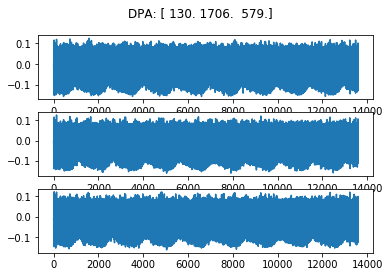

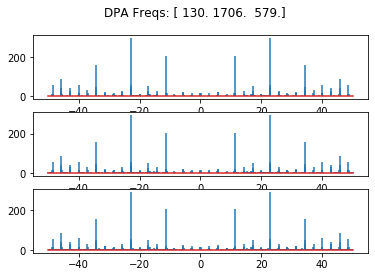

In [6]:
#ASCAD: Adapted by Mahmoud Gharra

# NOTE: code could take another database if it has the same format as the one provided.
# NOTE: you need to make a local directory with the name of your chosen training_model

###################
###################
# Hyper parameters:
###################

tot = 3 # total number of random samples that you'd like to display
f_s = 100 # frequency of data in Hz --- I can't seem to find this value in proj

tst_len = 30 # length of testing set

###################
###################

# if __name__ == "__main__":

if len(sys.argv)!=2:
    #default parameters values
#     my_database = "PRE_MAY_06/projects/operand_scanning_32"
#     DB_title = "operand_scanning_32"

#     my_database = "schoolbook32/schoolbook32"        
#     my_database = "../2020_APR_23/polymul32/projects/operand_scanning_32"
#     DB_title = "schoolbook32"

#     my_database = "../GSprojectNils/projects/GStraces"
#     my_database = "../2020_APR_23/polymul32/projects/operand_scanning_32"
#     DB_title = "Gaussian Sampler"

    my_database = "../DPA/DPA_contestv4_rsm/00000"
    meta_db = "../DPA/dpav4_rsm_index.txt"
    DB_title = "DPA"
    
    # TRAINING MODEL IS THE FILE, IN WHICH THE DATA SHOULD BE SAVED
else:
    #get parameters from user input
    DB_title, database = read_parameters_from_file(sys.argv[1])

# loads traces
print("+ Commense loading data")
# X, y = load_database(my_database)
X, y = load_database_DPA(my_database, meta_db)
print("++ Data dimestions are: ", np.array(X).shape)

print("+ sample {0} traces".format(tot))
if tot != 0:
    sample_traces(X)
    
save_db(DB_title, traces=X, labels=y)

In [7]:
# It looks like we have PowerLine intereference:
# This should fix it but I can't download matlab...
# I need conda for it, which I also don't have
# -- https://github.com/mrezak/removePLI
# import matlab.engine
# eng = matlab.engine.start_matlab()

In [8]:
# High and low pass filtering https://mne.tools/0.13/auto_tutorials/plot_artifacts_correction_filtering.html

In [9]:
# project = cw.open_project(my_database)

# print('location (project.location): ', project.location)
# print()

# print('trace length (project.waves[0].size): ', project.waves[0].size)
# print()

# print('number of traces (len(project.traces)): ', len(project.traces))
# print()
# print()

# # Iterable for working with only the text in.
# # Each item in the iterable is a byte array.
# # Supports iterating, indexing, and slicing:
# print("project.textins[0].size", project.textins[0].size)
# print("project.textins[0]", project.textins[0])
# print("project.textins (an iterable of length 64): ", project.textins)
# print()
# print("len(project.textins[0].tobytes())", len(project.textins[0].tobytes()))
# print()
# print()

# # Iterable for working with only the text out.
# # Each item in the iterable is a byte array.
# # Supports iterating, indexing, and slicing:
# print("project.textouts[0] (always False ... What is it?): ", project.textouts[0])
# print()
# print()

# # An output for all 64 keys with . 
# print("num. of keys (project.keys[0].size): ", project.keys[0].size)
# print("max index of labelled traces (project.keys.max): ", project.keys.max)
# print("number of classes")
# print()

# # keys_set = set(project.keys[0])


# # the following 4 lines are for the Gaussian sampler
# keys_set = set([])
# for i in range(len(project.keys[0])):
#     keys_set = keys_set.union(set(project.keys[i]))


# print("keys_set = set(project.keys[0]) -- (not well implemented... Assumes all key labels are in first trace):", keys_set)
# print("number of classes (based on keys_set) -- (len(keyset)): ", len(keys_set))
# print()
# print()

# print("file name (project.get_filename()): ", project.get_filename())
# print()

# print("length of singular traces (project.trace_manager().num_points()): ", project.trace_manager().num_points())
# print("number total of traces (project.trace_manager().num_traces()): ", project.trace_manager().num_traces())
# print()



In [10]:
# # https://stackoverflow.com/questions/50590175/how-to-create-multiple-plots-with-scrollable-x-axis-with-a-single-slider

# %matplotlib inline
# from ipywidgets import interactive
# import matplotlib.pyplot as plt
# import numpy as np

# def f(m):
#     plt.figure(2)
#     x = np.linspace(0, 1000, num=2000)
#     plt.plot(x,x)
#     #plt.plot(x, m * x)
#     plt.xlim(m, m+100)
#     plt.show()

# interactive(f, m=(0, 900.0))


# def f2(m):
#     t = np.arange(X.shape[1])
#     myTraces = np.array(X)

# #     plt.plot(x,x)
#     plt.plot(t, myTraces[243])
#     plt.xlim(m, m+500)
#     plt.show()

# interactive(f2, m=(0, 4500.0))



# def f3(m):
#     t = np.arange(X.shape[1])
#     myTraces = np.array(X)

# #     plt.plot(x,x)
#     plt.plot(t, myTraces[563])
#     plt.xlim(m, m+500)
#     plt.show()

# interactive(f3, m=(0, 4500.0))



# def f4(m):
#     t = np.arange(X.shape[1])
#     myTraces = np.array(X)

# #     plt.plot(x,x)
#     plt.plot(t, myTraces[1000])
#     plt.xlim(m, m+500)
#     plt.show()

# interactive(f4, m=(0, 4500.0))

In [11]:
# X.shape

In [12]:
# y.shape

In [13]:
# y[1]

In [14]:

# # returns traces and labels, as well as some important global meta_data

# def load_database2(my_database):
#     # load traces
#     print("++ Loading projects")
#     project = cw.open_project(my_database)
#     global KEY_LENGTH, TEXT_LENGTH, SAMPLE_HIGH, TRAINING_SLICE, TEST_NUM, TEST_SLICE

#     # Organize trace data for MLP
#     print("++ Organizing traces")
#     KEY_LENGTH = TEXT_LENGTH = project.keys[0].size

#     sample_low = 0
#     SAMPLE_HIGH = project.trace_manager().num_points() # length of singular trace
#     sample_slice = slice(sample_low, SAMPLE_HIGH)
#     sample_num = len(project.traces) # number of traces
# #     print("sample num: ", sample_num)
#     training_num = sample_num - tst_len
#     TRAINING_SLICE = slice(0, training_num)

#     TEST_NUM = sample_num - training_num
#     TEST_SLICE = slice(training_num, TEST_NUM + training_num)
#     assert TEST_NUM + training_num <= sample_num
#     assert training_num > 3*TEST_NUM

#     # organize traces in X matrix
#     X = empty(shape=(sample_num, SAMPLE_HIGH - sample_low))
#     for i in range(sample_num):
#         X[i] = project.waves[i][sample_slice]

#     # organize the operands in Y matrix
#     y = empty(shape=(sample_num, KEY_LENGTH))
#     for i in range(sample_num):
#         # reproduce values
#         y[i] = project.keys[i]
# #         text_num = text_gen(seed=i)[:TEXT_LENGTH]
# #         key_num = key_gen(seed=i)[:KEY_LENGTH]
# #         y[i][:] = key_num[:]
#         #y[i][y[i] > 2**15] -= 2**16

    
#     # transform generated key numbers to labels
#     unique = np.unique(y)
#     class_dic = dict([[unique[i], i] for i in range(len(unique))])
#     y_labelled = np.vectorize(class_dic.get)(y)

#     y_orig = y
#     return X, y_labelled, y_orig



In [15]:
# X_new, y_l, y_or = load_database2(my_database)

In [16]:
# X_new.shape

In [17]:
# y_l.shape

In [18]:
# print(y_or.shape)
# print(y_or[0].shape)
# print(y_or[0])

# print()

# print(y_or[1].shape)
# print(y_or[1])

# print()

# print(np.array((y_or[0]*(2**8)) + y_or[1], dtype=int))

In [19]:
# print(y_or[0])
# # print(y_or[0][0::2])
# # print(y_or[0][::2][8]) # even indices
# # print(y_or[0][1::2][8]) # odd indices
# print(np.array((y_or.T[1::2].T*(2**8)) + y_or.T[::2].T, dtype=np.int16).shape)
# print(np.array((y_or.T[1::2].T*(2**8)) + y_or.T[::2].T, dtype=np.int16))

In [20]:
# from collections import Counter
# print(np.sum(np.array((y_or.T[1::2].T*(2**8)) + y_or.T[::2].T, dtype=np.int16) == -1))
# np.array((y_or.T[1::2].T*(2**8)) + y_or.T[::2].T, dtype=np.int16).shape


In [21]:
# 15000 * 32

In [22]:
# 90180 / 480000

In [23]:
# my_database = "../GSproject/projects/GStraces"
# project = cw.open_project(my_database)

# print("total number of traces: {}".format(project.keys.max + 1))

# # see if all keys have correct length (32)
# count = 0
# myDict = dict()
# for i in range(project.keys.max):
#     if (len(np.asarray(bytearray(project.keys[i])))) is not 32:
#         myDict[i]= len(np.asarray(bytearray(project.keys[i])))
#         count += 1

# print("number of traces not containing 32 instances of our 8-bit key: {}".format(count)) # should be 0
# print("indices of problematic traces and their length (ind: length): {}".format(myDict)) # should be empty


# # quick sanity check for all key instances
# mySet = set([])
# for i in range(project.keys.max):
#     mySet = mySet.union(np.unique(np.asarray(bytearray(project.keys[i]))))

# print("appearing key instances (256 is correct): {}".format(len(mySet)))

In [24]:
# my_database = "../GSproject/projects/GStraces"
# project = cw.open_project(my_database)

# print("total number of traces: {}".format(project.keys.max + 1))

# # see if all keys have correct length (32)
# count = 0
# myDict = dict()
# KEY_LENGTH = 32 * 8
# sample_num = len(project.traces)

# y = empty(shape=(sample_num, KEY_LENGTH * 8))

# # np.asarray(bytearray(project.keys[0]))

# # ''.join(['{0:08b}'.format(ff) for ff in np.asarray(bytearray(project.keys[0]))])

# for i in range(50):
#     print(np.asarray([int(char) for char in ''.join(['{0:08b}'.format(ff) for ff in np.asarray(bytearray(project.keys[i]))])])[0:30])



In [25]:
# import codecs
# encodings = ['utf-8', 'windows-1250', 'windows-1252', 'utf-16', "ascii", 'cp037']# ...etc]
# for e in encodings:
#     try:
#         fh = project.keys[0].decode(e)
#     except UnicodeDecodeError:
#         print('got unicode error with %s , trying different encoding' % e)
#     else:
#         print('opening the file with encoding:  %s ' % e)
#         print('it looks like this: {}'.format(fh))
        

In [26]:
# bytearray(b'0q(K\xa6\xd5\xb7C\xefx\x8fq\x87\x9c\xd0)\x86a\x05V\x14\x03#\xa9!b\xf9\r\xd0\xd0v\xcf')

In [27]:
# np.asarray(bytearray(b'0q(K\xa6\xd5\xb7C\xefx\x8fq\x87\x9c\xd0)\x86a\x05V\x14\x03#\xa9!b\xf9\r\xd0\xd0v\xcf'))

In [28]:
# np.asarray(bytearray(b'0q(K\xa6\xd5\xb7C\xefx\x8fq\x87\x9c\xd0)\x86a\x05V\x14\x03#\xa9!b\xf9\r\xd0\xd0v\xcf')).size

In [29]:


# a = np.array([[1, 2, 3, 4],
# [5, 6, 7, 8],
# [9, 10, 11, 12],
# [13, 14, 15, 16]])

# count = 0
# print("a:\n{}".format(a))
# for i in range(1, 5):
#     print("a[0:-{}]:\n{}".format(i, a[0:-i]))

In [30]:
# # advs = np.load("./training_GAUSS_bitwise_mlp_batch100_epochs2_MAXATT1_lr1e-4_valid1e-1/tst_acc.npy", allow_pickle=True)
# advs = np.load("./training_GAUSS_bitwise_cnn_batch100_epochs5_MAXATT1_lr1e-4_valid1e-1/tst_acc.npy", allow_pickle=True)

In [31]:
# set(advs.tolist().values())

In [32]:
# advs.tolist().values()